# Model TCNN Time Series for COVID : Training

This notebook explore from official "Sante Publique France" data about COVID-19 in France


These data have 4-days time delay.

The time series model is created and trained to predict future 7 next days (output) based on 14 past last days (input).


**Input Features are daily data of:**

- Min/Max Temperatures
- Min/Max Humidities
- nb. Confirmed cases
- nb. Tested cases
- Day of the week
- Mean Age of Tested cases
- Mean Age of Confirmed cases

**DATA sources:**

Tested / Confirmed cases: https://www.data.gouv.fr/fr/datasets/donnees-relatives-aux-resultats-des-tests-virologiques-covid-19

Météo France : https://public.opendatasoft.com/explore/dataset/donnees-synop-essentielles-omm

**GitHub:** https://github.com/jeugregg/coronavirusModel

## import

In [1]:
%matplotlib inline

# figure lib
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import seaborn as sns
sns.set(color_codes=True, font_scale=1.33)
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

# data useful lib
import pandas as pd
import numpy as np

# helper lib
import shutil
import os, stat
import re
import datetime
import math

# read json from http
import json
import urllib.request

# read csv from http
import io
import requests

# model lib
import tensorflow as tf
from sklearn.metrics import mean_absolute_error

# projects libs
from my_helpers.data_plots import get_data_pos
from my_helpers.data_plots import load_data_pos
from my_helpers.data_plots import get_old_data_pos
from my_helpers.data_plots import load_old_data_pos
from my_helpers.data_plots import PATH_DF_GOUV_FR_OLD
from my_helpers.model import multivariate_data
from my_helpers.model import prepare_to_lambda
from my_helpers.model import retrieve_from_lambda
from my_helpers.model import create_list_past_hist
from my_helpers.model import predict_list

## Definitions

In [2]:
mode_train = True

In [3]:
PATH_TO_SAVE_DATA = "."
PATH_DF_POS_FR = PATH_TO_SAVE_DATA + '/' + 'df_pos_fr.csv'
PATH_DF_TEST_FR = PATH_TO_SAVE_DATA + '/' + 'df_test_fr.csv'
PATH_JSON_METEO_FR = PATH_TO_SAVE_DATA + '/' + 'data_meteo_fr.json'
PATH_DF_FEAT_FR = PATH_TO_SAVE_DATA + '/' + 'df_feat_fr.csv' 
PATH_GEO_DEP_FR = PATH_TO_SAVE_DATA + '/sources/geofrance/' + 'departments.csv'
PATH_MDL_SINGLE_STEP = PATH_TO_SAVE_DATA + '/' + "mdl_single_step_pos_fr"
PATH_MDL_MULTI_STEP = PATH_TO_SAVE_DATA + '/' + "mdl_multi_step_pos_fr"
PATH_MDL_MULTI_TFLITE = PATH_TO_SAVE_DATA + '/' + \
    'serverless/tensorflow_lite_on_aws_lambda'
PATH_MDL_MULTI_TFLITE_FILE = PATH_MDL_MULTI_TFLITE + '/' + \
    "converted_model.tflite"
PATH_SERVERLESS = PATH_MDL_MULTI_TFLITE + '/' + 'serverless.yml'

date_format = "%Y-%m-%d"

#NB_POS_DATE_MIN_DF_FEAT = 140734 # on 13/05/2020
NB_POS_DATE_MIN_DF_FEAT = 140227 # on 12/05/2020

URL_PREDICT = 'https://yl0910jrga.execute-api.us-east-2.amazonaws.com/dev/infer'

# model 
PAST_HISTORY = 14 # days used to predict next values in future
FUTURE_TARGET = 7 # nb predict days later
STEP = 1

# plot
nb_period_plot = 15
NB_DAY_PLOT = FUTURE_TARGET*nb_period_plot

##  Helper functions

In [4]:
# FOR MODEL
"""def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
    '''
    Create dataset for training : create each samples (timeseries data)
    '''
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i, step)
        data.append(dataset[indices])

        if single_step:
            labels.append(target[i+target_size])
        else:
            labels.append(target[i:i+target_size])

    return np.array(data), np.array(labels)"""

# FOR DATES
def add_days(str_date_0, nb_days_CV):
    '''
    add days to string dates
    '''
    date_format = "%Y-%m-%d"
    date_last = datetime.datetime.strptime(str_date_0, date_format)
    date_start = date_last + datetime.timedelta(days=nb_days_CV)
    str_date_start = date_start.strftime(date_format)
    return str_date_start

def generate_list_dates(str_date_0, str_date_1, step=1, date_format=None):
    if date_format is None:
        date_format = "%Y-%m-%d"
    date_0 = datetime.datetime.strptime(str_date_0, date_format)
    date_1 = datetime.datetime.strptime(str_date_1, date_format)
    delta = date_1 - date_0
    if delta.days > 0:
        return [(date_0 + \
                 datetime.timedelta(days=I)).strftime(date_format) \
               for I in range(1, delta.days+1, step)]
    else:
        return None


# For Training plots
def create_time_steps(length):
    '''
    create time steps
    '''
    return list(range(-length, 0))

def plot_train_history(history, title):
    """
    Plot train errors
    """
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(loss))

    plt.figure()

    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title(title)
    plt.legend()

    plt.show()
    
# save file before update
def clean_file(path_file_name):
    '''
    Clean file already traited : rename file with date
    '''
    try:
        d = datetime.datetime.now()
        str_date = '_' + d.strftime("%Y%m%d_%H_%M_%S")
       
        res_re = re.search('\.\w+$', path_file_name)
        
        path_file_name_saved = \
            path_file_name[0:res_re.start()] + str_date + res_re.group(0)
         
        shutil.move(path_file_name, path_file_name_saved) 
        print('File {} moved!'.format(path_file_name_saved))
    except:
        print('File {} does not exist!'.format(path_file_name))

## Retrieve data

In [7]:
get_data_pos()
df_feat_fr = load_data_pos()

No new data meteo


## Retrieve old data

In [10]:
if not os.path.isfile(PATH_DF_GOUV_FR_OLD):
    get_old_data_pos()
    
df_feat_fr_old = load_old_data_pos()

df_feat_fr_old

date       T_min       T_max      H_min      H_max  pos  \
date                                                                        
2020-03-10  2020-03-10  283.708333  289.736667  70.666667  90.416667    8   
2020-03-11  2020-03-11  285.335000  291.913333  66.183333  91.383333   16   
2020-03-12  2020-03-12  284.048333  290.268333  63.866667  89.883333   33   
2020-03-13  2020-03-13  282.503333  289.148333  56.150000  88.500000   61   
2020-03-14  2020-03-14  282.253333  289.338333  62.116667  88.683333   54   
...                ...         ...         ...        ...        ...  ...   
2020-05-08  2020-05-08  287.051695  296.029661  53.568966  86.327586   15   
2020-05-09  2020-05-09  288.019492  295.305932  60.448276  87.448276   29   
2020-05-10  2020-05-10  288.058621  293.532759  68.228070  92.649123   17   
2020-05-11  2020-05-11  284.517797  290.512712  67.310345  90.396552  210   
2020-05-12  2020-05-12  283.870000  289.811667  61.932203  86.322034  168   

              age_pos   test   age_test  day_num  nb_cases  
date                                                        
2020-03-10  66.625000     79  50.696203        2    101343  
2020-03-11  44.875000    108  45.587963        3    101359  
2020-03-12  58.681818    156  49.362179        4    101392  
2020-03-13  49.073770    350  44.335714        5    101453  
2020-03-14  51.222222    167  48.664671        6    101507  
...               ...    ...        ...      ...       ...  
2020-05-08  65.366667    448  59.638393        5    139803  
2020-05-09  45.431034   1513  52.868804        6    139832  
2020-05-10  61.676471    293  60.738908        0    139849  
2020-05-11  63.357143  10339  53.020892        1    140059  
2020-05-12  63.345238  10567  51.926706        2    140227  

[64 rows x 11 columns]

## Train/Test split

In [11]:
df_feat_fr = pd.read_csv(PATH_DF_FEAT_FR)
df_feat_fr.index = df_feat_fr["date"]

df_feat_fr

T_min        date       T_max      H_min      H_max  extrap  \
date                                                                           
2020-05-13  284.926667  2020-05-13  290.505000  64.661017  88.135593     0.0   
2020-05-14  285.050000  2020-05-14  290.963333  59.406780  84.847458     0.0   
2020-05-15  285.308333  2020-05-15  291.920000  57.372881  82.966102     0.0   
2020-05-16  284.956667  2020-05-16  293.500000  53.741379  86.534483     0.0   
2020-05-17  285.598333  2020-05-17  294.446667  49.879310  85.500000     0.0   
...                ...         ...         ...        ...        ...     ...   
2020-12-06  280.743220  2020-12-06  285.511017  71.466667  91.466667     0.0   
2020-12-07  280.146667  2020-12-07  284.930000  74.750000  92.166667     0.0   
2020-12-08  280.886667  2020-12-08  285.320000  70.583333  91.000000     0.0   
2020-12-09  280.412712  2020-12-09  285.056780  72.949153  90.322034     0.0   
2020-12-10  281.256667  2020-12-10  286.038333  73.983333  92.816667     0.0   

              pos    age_pos    test   age_test  day_num  nb_cases  
date                                                                
2020-05-13    881  61.023837   39033  55.429508        3    141108  
2020-05-14    979  60.426966   41967  54.825625        4    142087  
2020-05-15   1021  60.042116   47661  54.378842        5    143108  
2020-05-16    291  60.158076   16510  54.487280        6    143399  
2020-05-17    139  61.568345    6597  58.294831        0    143538  
...           ...        ...     ...        ...      ...       ...  
2020-12-06   1739  56.433007   25895  55.190577        0   2249470  
2020-12-07  16575  50.559698  253218  52.568854        1   2266045  
2020-12-08  13117  50.974842  221802  51.690801        2   2279162  
2020-12-09  12610  49.972403  202758  50.257657        3   2291772  
2020-12-10  13344  50.535821  220806  50.638062        4   2305116  

[212 rows x 12 columns]

In [12]:
if mode_train:
    # keep 25 Validation samples:
    TRAIN_SPLIT = df_feat_fr.shape[0] - (2 * FUTURE_TARGET)
    #TRAIN_SPLIT = 45
else:
    from my_helpers.model import TRAIN_SPLIT
print(f"TRAIN_SPLIT = {TRAIN_SPLIT}")

TRAIN_SPLIT = 198


In [13]:
df_feat_fr["train"] = [True if I <= TRAIN_SPLIT else False \
                       for I in range(df_feat_fr.shape[0])]
df_feat_fr

T_min        date       T_max      H_min      H_max  extrap  \
date                                                                           
2020-05-13  284.926667  2020-05-13  290.505000  64.661017  88.135593     0.0   
2020-05-14  285.050000  2020-05-14  290.963333  59.406780  84.847458     0.0   
2020-05-15  285.308333  2020-05-15  291.920000  57.372881  82.966102     0.0   
2020-05-16  284.956667  2020-05-16  293.500000  53.741379  86.534483     0.0   
2020-05-17  285.598333  2020-05-17  294.446667  49.879310  85.500000     0.0   
...                ...         ...         ...        ...        ...     ...   
2020-12-06  280.743220  2020-12-06  285.511017  71.466667  91.466667     0.0   
2020-12-07  280.146667  2020-12-07  284.930000  74.750000  92.166667     0.0   
2020-12-08  280.886667  2020-12-08  285.320000  70.583333  91.000000     0.0   
2020-12-09  280.412712  2020-12-09  285.056780  72.949153  90.322034     0.0   
2020-12-10  281.256667  2020-12-10  286.038333  73.983333  92.816667     0.0   

              pos    age_pos    test   age_test  day_num  nb_cases  train  
date                                                                       
2020-05-13    881  61.023837   39033  55.429508        3    141108   True  
2020-05-14    979  60.426966   41967  54.825625        4    142087   True  
2020-05-15   1021  60.042116   47661  54.378842        5    143108   True  
2020-05-16    291  60.158076   16510  54.487280        6    143399   True  
2020-05-17    139  61.568345    6597  58.294831        0    143538   True  
...           ...        ...     ...        ...      ...       ...    ...  
2020-12-06   1739  56.433007   25895  55.190577        0   2249470  False  
2020-12-07  16575  50.559698  253218  52.568854        1   2266045  False  
2020-12-08  13117  50.974842  221802  51.690801        2   2279162  False  
2020-12-09  12610  49.972403  202758  50.257657        3   2291772  False  
2020-12-10  13344  50.535821  220806  50.638062        4   2305116  False  

[212 rows x 13 columns]

## Exploration

Distribution of TRAIN / VALIDATION dataset :

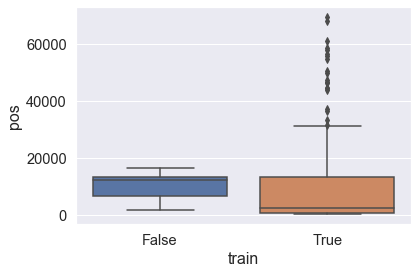

In [14]:
ax = sns.boxplot(x="train", y="pos", data=df_feat_fr)

### age

#### First wave

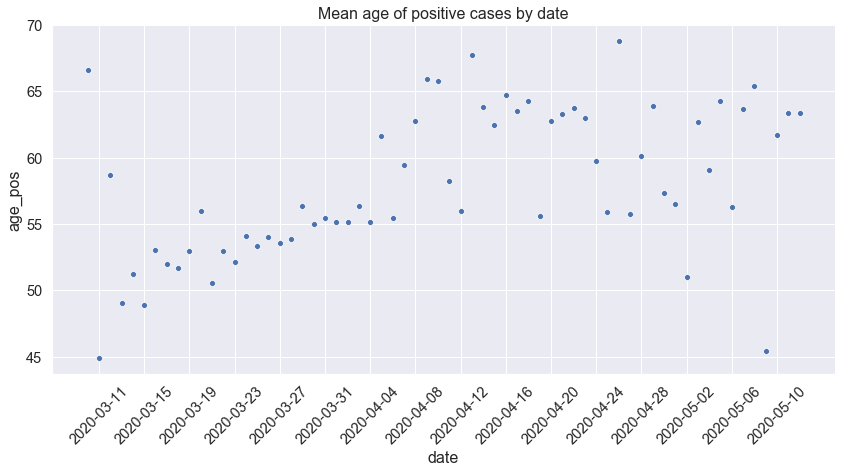

In [15]:
sns.relplot(x="date", y="age_pos", data=df_feat_fr_old, height=6, aspect=2);
plt.xticks(generate_list_dates(df_feat_fr_old["date"].min(), 
                    df_feat_fr_old["date"].max(), 4))
plt.xticks(rotation=45);
plt.title("Mean age of positive cases by date");

#### Second wave

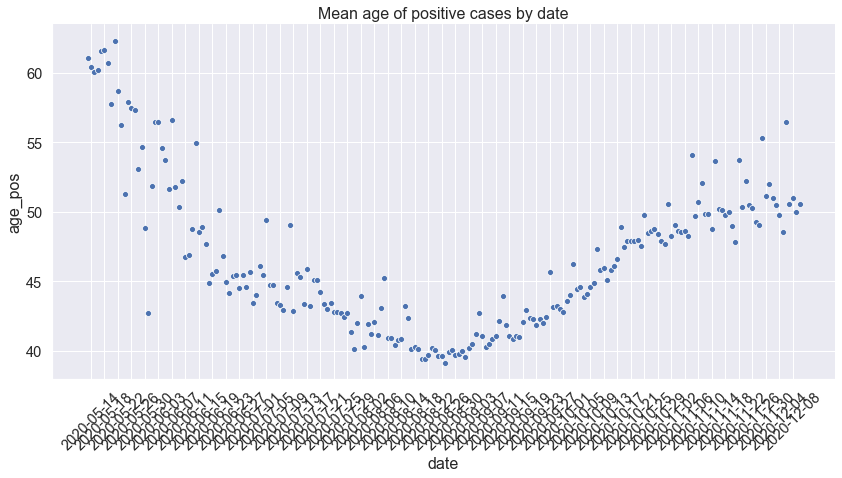

In [16]:
sns.relplot(x="date", y="age_pos", data=df_feat_fr, height=6, aspect=2);
plt.xticks(generate_list_dates(df_feat_fr["date"].min(), 
                    df_feat_fr["date"].max(), 4))
plt.xticks(rotation=45);
plt.title("Mean age of positive cases by date");

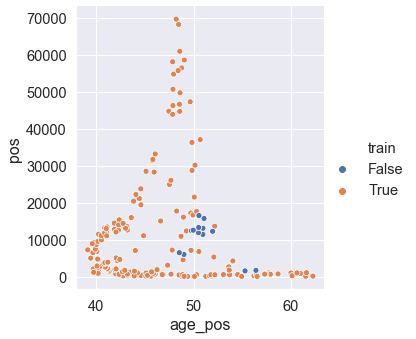

In [17]:
sns.relplot(x="age_pos", y="pos", hue="train", data=df_feat_fr);

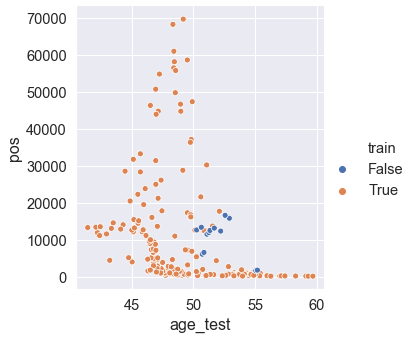

In [18]:
sns.relplot(x="age_test", y="pos", hue="train", data=df_feat_fr);

### Impact of day 

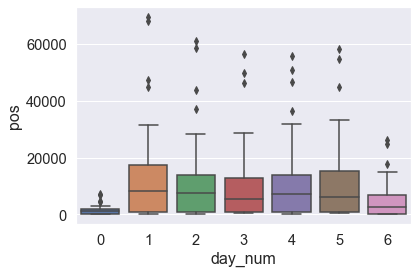

In [19]:
ax = sns.boxplot(x="day_num", y="pos", data=df_feat_fr)

=> It is not the reality. On weekend, a lot of local medical structures don't trace positive cases.

### Temperature impact

In [20]:
df_feat_fr["T_mean"] = 0.5 * (df_feat_fr["T_min"] + df_feat_fr["T_max"])

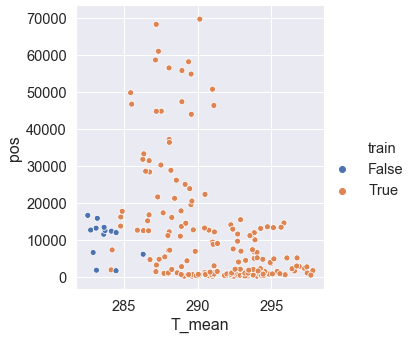

In [21]:
sns.relplot(x="T_mean", y="pos", hue="train", data=df_feat_fr);

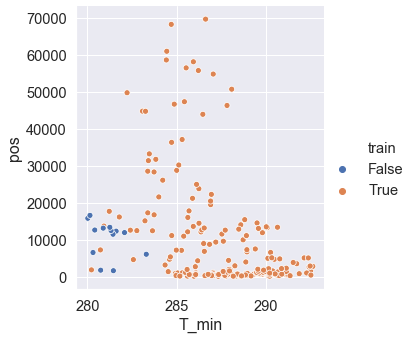

In [22]:
sns.relplot(x="T_min", y="pos", hue="train", data=df_feat_fr);

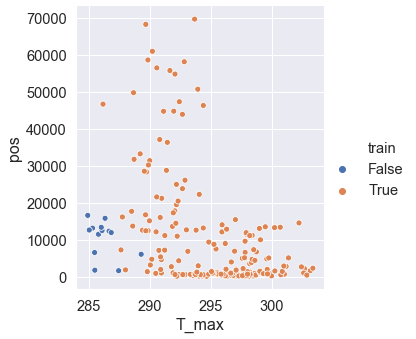

In [23]:
sns.relplot(x="T_max", y="pos", hue="train", data=df_feat_fr);

Impact of cold temperature :

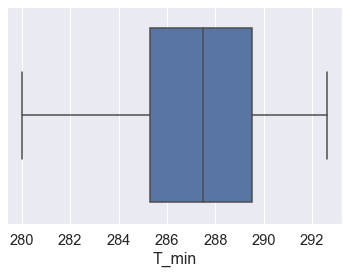

In [24]:
ax = sns.boxplot(x="T_min", data=df_feat_fr)

In [25]:
df_feat_fr["T_min"].mean()

287.1301909345472

In [26]:
(df_feat_fr["T_min"] < df_feat_fr["T_min"].mean()).value_counts()

False    114
True      98
Name: T_min, dtype: int64

In [27]:
(df_feat_fr["T_min"] < df_feat_fr["T_min"].median()).value_counts()

True     106
False    106
Name: T_min, dtype: int64

In [28]:
df_feat_fr["T_min"].median()

287.5053389830509

In [29]:
df_feat_fr["cold_min"] = df_feat_fr["T_min"] < df_feat_fr["T_min"].median()

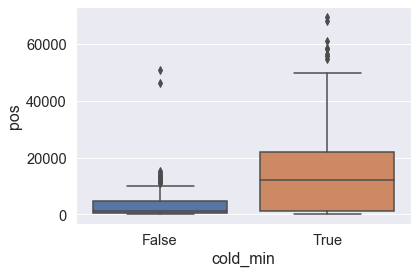

In [30]:
ax = sns.boxplot(x="cold_min", y="pos", data=df_feat_fr)

=> colder T min then more positive cases! but trend is not clear (more deviation with cold temperature)

Impact of T mean : 

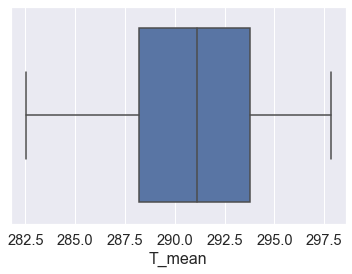

In [31]:
ax = sns.boxplot(x="T_mean", data=df_feat_fr)

In [32]:
df_feat_fr["T_mean"].median()

291.11641242937856

In [33]:
df_feat_fr["cold_mean"] = df_feat_fr["T_mean"] < df_feat_fr["T_mean"].median()

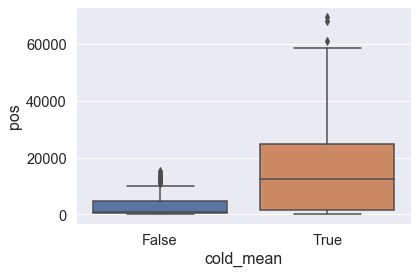

In [34]:
ax = sns.boxplot(x="cold_mean", y="pos", data=df_feat_fr)

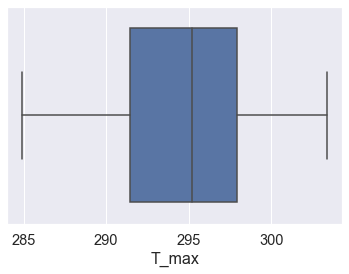

In [35]:
ax = sns.boxplot(x="T_max", data=df_feat_fr)

In [36]:
df_feat_fr["T_max"].median()

295.20500000000004

In [37]:
df_feat_fr["cold_max"] = df_feat_fr["T_max"] < df_feat_fr["T_max"].median()

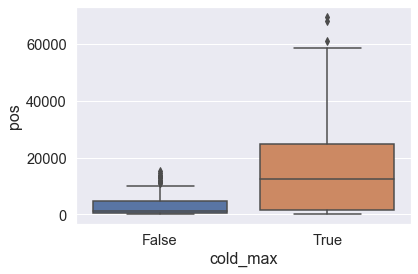

In [38]:
ax = sns.boxplot(x="cold_max", y="pos", data=df_feat_fr)

=> like T min

### Impact of Humidity

In [39]:
df_feat_fr["H_mean"] = 0.5 * (df_feat_fr["H_min"] + df_feat_fr["H_max"])

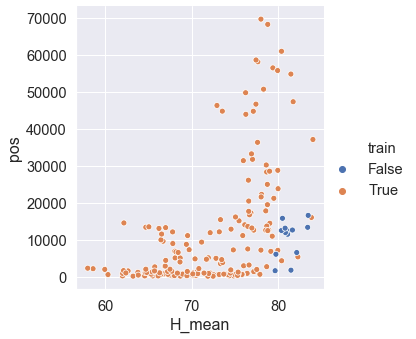

In [40]:
sns.relplot(x="H_mean", y="pos", hue="train", data=df_feat_fr);

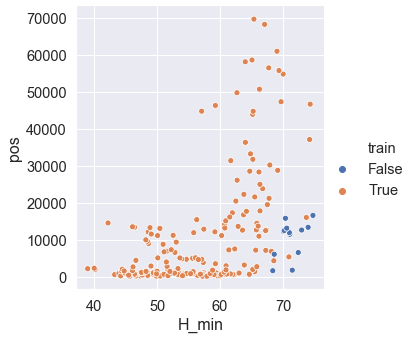

In [41]:
sns.relplot(x="H_min", y="pos", hue="train", data=df_feat_fr);

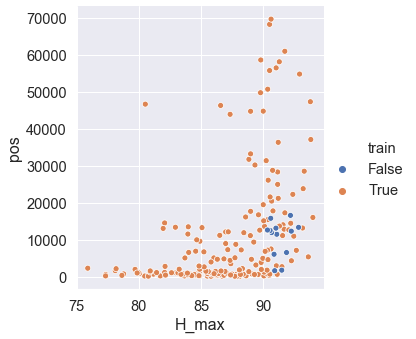

In [42]:
sns.relplot(x="H_max", y="pos", hue="train", data=df_feat_fr);

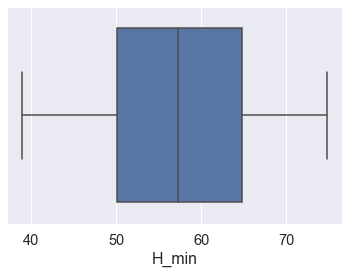

In [43]:
ax = sns.boxplot(x="H_min", data=df_feat_fr)

In [44]:
df_feat_fr["H_min"].median()

57.290911747516084

In [45]:
df_feat_fr["dry_min"] = df_feat_fr["H_min"] < df_feat_fr["H_min"].median()

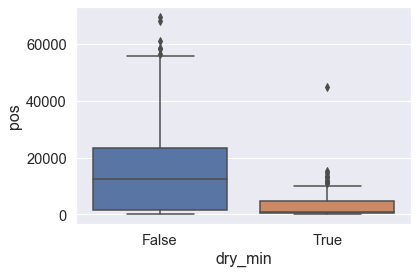

In [46]:
ax = sns.boxplot(x="dry_min", y="pos", data=df_feat_fr)

=> more DRY, less positive cases

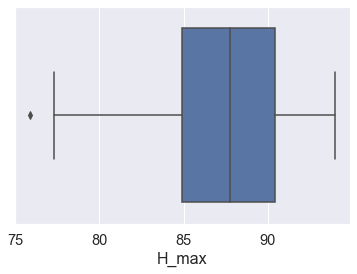

In [47]:
ax = sns.boxplot(x="H_max", data=df_feat_fr)

In [48]:
df_feat_fr["H_max"].median()

87.76052016364699

In [49]:
df_feat_fr["dry_max"] = df_feat_fr["H_max"] < df_feat_fr["H_max"].median()

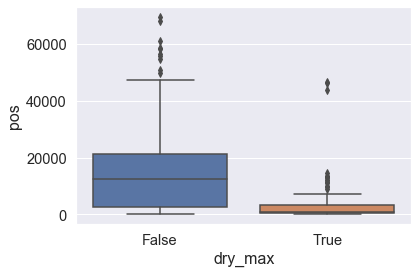

In [50]:
ax = sns.boxplot(x="dry_max", y="pos", data=df_feat_fr)

=> => Same than H min

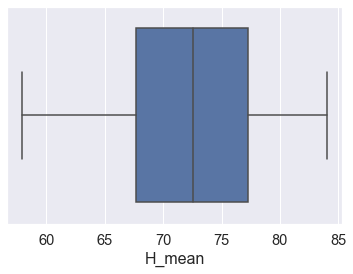

In [51]:
ax = sns.boxplot(x="H_mean", data=df_feat_fr)

In [52]:
df_feat_fr["H_mean"].median()

72.57758620689654

In [53]:
df_feat_fr["dry_mean"] = df_feat_fr["H_mean"] < df_feat_fr["H_mean"].median()

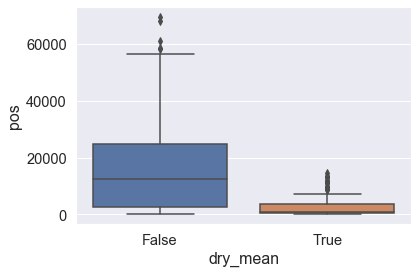

In [54]:
ax = sns.boxplot(x="dry_mean", y="pos", data=df_feat_fr)

=> Same H min

### Seasonality impact

In [55]:
df_feat_fr["month"] = df_feat_fr["date"].astype(np.datetime64).dt.month

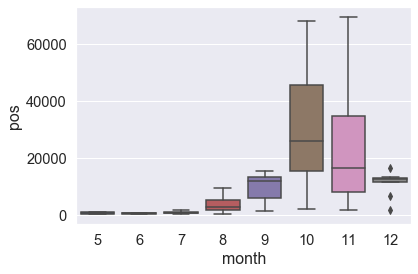

In [56]:
ax = sns.boxplot(x="month", y="pos", data=df_feat_fr)

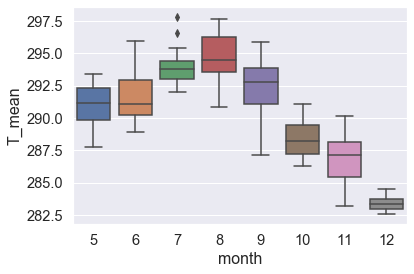

In [57]:
ax = sns.boxplot(x="month", y="T_mean", data=df_feat_fr)

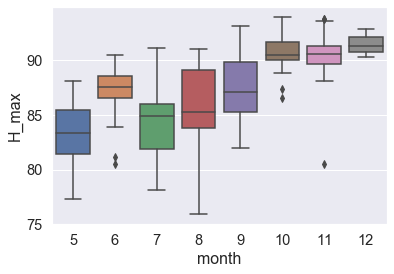

In [58]:
ax = sns.boxplot(x="month", y="H_max", data=df_feat_fr)

In [59]:
pt_month = df_feat_fr.pivot_table(values=["pos"],
                           index="month", aggfunc=np.sum)
pt_month

pos
month        
5       11736
6       14616
7       24757
8      105822
9      293248
10     932445
11     670186
12     112079

### Nb Tested

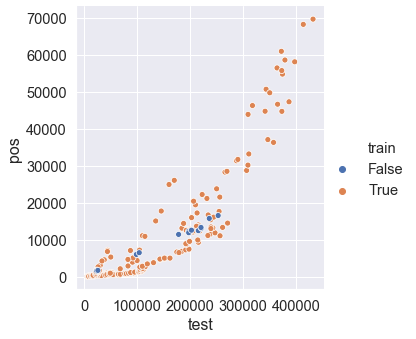

In [60]:
sns.relplot(x="test", y="pos", hue="train", data=df_feat_fr);

In [61]:
fig = go.Figure()
# Create and style traces
fig.add_trace(go.Scatter(x=df_feat_fr_old["date"].astype(np.datetime64), 
                         y=df_feat_fr_old["test"],
                    mode='lines+markers',
                    line_shape='linear',
                    connectgaps=True, name="Nb. Tested - 1st wave"))
fig.add_trace(go.Scatter(x=df_feat_fr["date"].astype(np.datetime64), 
                         y=df_feat_fr["test"],
                    mode='lines+markers',
                    line_shape='linear',
                    connectgaps=True, name="Nb. Tested"))
# Edit the layout
fig.update_layout(title='COVID-19 Tested  (France)',
                   yaxis_title='nb Tested')
fig.update_layout(legend_orientation="h", legend=dict(x=0, y=1.1))
fig.show()

In [62]:
fig = go.Figure()
# Create and style traces
fig.add_trace(go.Scatter(x=df_feat_fr_old["date"].astype(np.datetime64), 
                         y=100*df_feat_fr_old["pos"] / df_feat_fr_old["test"],
                    mode='lines+markers',
                    line_shape='linear',
                    connectgaps=True, name="Positive Rate - 1st wave"))
fig.add_trace(go.Scatter(x=df_feat_fr["date"].astype(np.datetime64), 
                         y=100*df_feat_fr["pos"] / df_feat_fr["test"],
                    mode='lines+markers',
                    line_shape='linear',
                    connectgaps=True, name="Positive Rate"))
# Edit the layout
fig.update_layout(title='COVID-19 Positive rate  (France)',
                   yaxis_title='pos. rate [%]')
fig.update_layout(legend_orientation="h", legend=dict(x=0, y=1.1))
fig.show()

## Prepare features

In [16]:
df_feat_fr = pd.read_csv(PATH_DF_FEAT_FR)
df_feat_fr.index = df_feat_fr["date"]

In [17]:
features = df_feat_fr.copy().filter(items=['T_min', 'T_max', 'H_min',
                                           'H_max', 'pos', 'test', 'day_num',
                                          'age_pos', 'age_test'])
features

T_min       T_max      H_min      H_max    pos    test  \
date                                                                      
2020-05-13  284.926667  290.505000  64.661017  88.135593    881   38271   
2020-05-14  285.050000  290.963333  59.406780  84.847458    979   41070   
2020-05-15  285.308333  291.920000  57.372881  82.966102   1021   46480   
2020-05-16  284.956667  293.500000  53.741379  86.534483    291   15985   
2020-05-17  285.598333  294.446667  49.879310  85.500000    139    6192   
...                ...         ...        ...        ...    ...     ...   
2020-11-29  281.455000  287.461667  68.366667  90.900000   1239   11653   
2020-11-30  280.025000  286.350000  70.383333  90.583333  13080  111386   
2020-12-01  281.608333  286.676667  70.050000  92.233333  10174   91614   
2020-12-02  281.434746  285.809322  71.084746  91.067797   9390   81726   
2020-12-03  282.076667  286.855000  71.000000  90.650000   9517   86638   

            day_num    age_pos   age_test  
date                                       
2020-05-13        3  61.023837  55.403413  
2020-05-14        4  60.426966  54.784100  
2020-05-15        5  60.042116  54.290706  
2020-05-16        6  60.158076  54.310103  
2020-05-17        0  61.568345  57.966408  
...             ...        ...        ...  
2020-11-29        0  57.790960  54.081352  
2020-11-30        1  52.341590  51.591529  
2020-12-01        2  53.654905  50.536414  
2020-12-02        3  52.445048  49.404486  
2020-12-03        4  51.732269  49.979282  

[205 rows x 9 columns]

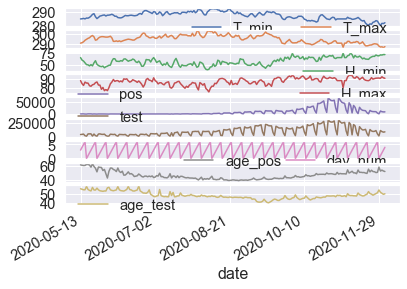

In [18]:
features.plot(subplots=True);

In [19]:
dataset = features.values
data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
data_std = dataset[:TRAIN_SPLIT].std(axis=0)
dataset = (dataset-data_mean)/data_std

In [20]:
dataset.shape

(205, 9)

## Multi-step model

### Helper functions

In [21]:
def multi_step_plot(history, true_future, prediction):
    plt.figure(figsize=(12, 6))
    num_in = create_time_steps(len(history))
    num_out = len(true_future)

    plt.plot(num_in, np.array(history[:, 4]), label='History')
    plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',
           label='True Future')
    if prediction.any():
        plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro',
             label='Predicted Future')
    plt.legend(loc='upper left')
    plt.show()

### data 14D_to_7D

In [22]:
TRAIN_SPLIT

191

In [23]:
dataset.shape

(205, 9)

In [24]:
x_train_multi, y_train_multi = multivariate_data(dataset, dataset[:, 4], 
                                0, TRAIN_SPLIT, PAST_HISTORY,
                                FUTURE_TARGET, STEP, single_step=False)

x_val_multi, y_val_multi = multivariate_data(dataset, dataset[:, 4],
                                TRAIN_SPLIT-PAST_HISTORY, None, PAST_HISTORY,
                                FUTURE_TARGET, STEP, single_step=False)

In [25]:
y_train_multi.shape

(177, 7)

In [26]:
print ('{} Single window of past history : {}'.format(x_train_multi.shape[0],
                                                      x_train_multi[0].shape))
print ('\n {} Target temperature to predict : {}'.format(y_train_multi.shape[0],
                                                        y_train_multi[0].shape))

177 Single window of past history : (14, 9)

 177 Target temperature to predict : (7,)


In [27]:
BATCH_SIZE = x_train_multi.shape[0]
BATCH_SIZE_VAL = y_val_multi.shape[0]
BUFFER_SIZE = TRAIN_SPLIT
tf.random.set_seed(0)

train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, 
                                                       y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE) \
    .batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE_VAL).repeat()

print("For Training : ")
print("BATCH_SIZE :", BATCH_SIZE)
print("BUFFER_SIZE :", BUFFER_SIZE)
print("\nFor validation : ")
print("BATCH_SIZE_VAL :", BATCH_SIZE_VAL)


For Training : 
BATCH_SIZE : 177
BUFFER_SIZE : 191

For validation : 
BATCH_SIZE_VAL : 7


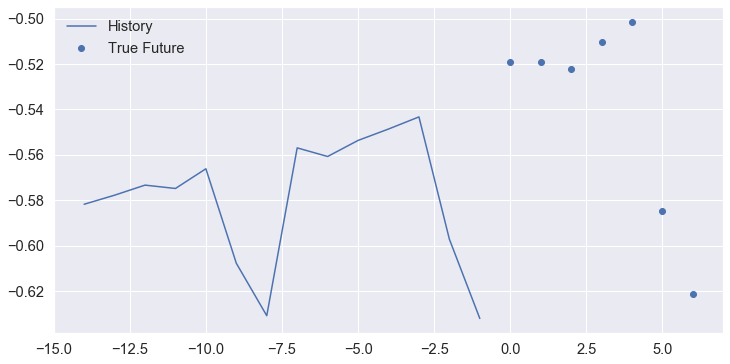

In [28]:
for x, y in train_data_multi.take(1):
    multi_step_plot(x[0], y[0], np.array([0]))

### Training

In [29]:
print(f"nb samples for training : {x_train_multi.shape[0]}")
print(f"nb samples for validation : {x_val_multi.shape[0]}")

nb samples for training : 177
nb samples for validation : 7


In [40]:
x_train_multi.shape[-2:]

(14, 9)

In [73]:
from tensorflow.keras.layers import Conv1D
# create model
multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(Conv1D(filters=1, 
                            kernel_size=2, 
                            padding='causal',
                            dilation_rate=2, 
                            activation=None,
                            input_shape=x_train_multi.shape[-2:],
                        kernel_initializer=tf.keras.initializers.Constant(1.),
                           use_bias=False))

#x = Conv1D(filters, kernel_size, strides=1, padding='causal', data_format='channels_last',
#    dilation_rate=1, groups=1, activation=None)

In [74]:
multi_step_model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_5 (Conv1D)            (None, 14, 1)             18        
Total params: 18
Trainable params: 18
Non-trainable params: 0
_________________________________________________________________


In [75]:
x_val_multi.shape

(7, 14, 9)

In [76]:
x_val_multi[0][np.newaxis,:,:].shape

(1, 14, 9)

In [77]:
y_tcnn = multi_step_model.predict(x_val_multi[0][np.newaxis,:,:])
y_tcnn.shape

(1, 14, 1)

In [78]:
x_val_multi[0][np.newaxis,:,:]

array([[[-1.2020162 , -1.3647638 ,  1.06651917,  0.31429898,
          2.21476553,  1.97555098,  1.00198646,  0.43619752,
         -0.07996859],
        [-1.2020162 , -1.3647638 ,  1.06651917,  0.31429898,
          0.48553742,  0.04825455,  1.50429464,  0.37677498,
         -0.3821671 ],
        [-0.67739093, -0.84647323,  1.56264603,  1.3960704 ,
         -0.37515796, -0.98050681, -1.50955441,  1.44018798,
          0.44280752],
        [-0.99122692, -0.83283667,  1.70910732,  1.79690329,
          2.37395371,  1.9657517 , -1.00724623,  0.63495378,
          0.01319207],
        [-1.04480546, -1.27557291,  2.29043974,  1.80672777,
          1.71921365,  1.53093214, -0.50493806,  0.82850829,
         -0.07519906],
        [-1.32327292, -1.25626354,  1.86989908,  1.7540328 ,
         -0.30943984, -0.85705595, -0.00262989,  1.08600041,
         -0.05293075],
        [-1.2943687 , -1.10316783,  0.98398856,  1.11730189,
          1.66679333,  1.49002862,  0.49967829,  0.67309259,
        

In [82]:
np.sum(x_val_multi[0][0])

4.362570042409919

In [87]:
np.sum(x_val_multi[0][-1]) + np.sum(x_val_multi[0][-3])

0.7727201855083916

In [84]:
y_tcnn

array([[[4.36257   ],
        [0.8467325 ],
        [4.815198  ],
        [6.5092845 ],
        [5.727935  ],
        [6.570891  ],
        [9.175415  ],
        [5.1636977 ],
        [6.2381    ],
        [3.8916426 ],
        [3.9593399 ],
        [0.31916136],
        [1.987198  ],
        [0.7727202 ]]], dtype=float32)

In [125]:
inputs = tf.keras.Input(shape=x_train_multi.shape[-2:])
print("inputs : ", inputs)
x1 = Conv1D(filters=128, 
           kernel_size=2, 
           padding='causal',
           dilation_rate=2, 
           activation=None,
           kernel_initializer=tf.keras.initializers.Constant(1.),
           use_bias=False)(inputs)
print("x1 : ", x1)
x2 = Conv1D(filters=128, 
           kernel_size=2, 
           padding='causal',
           dilation_rate=2, 
           activation=None,
           kernel_initializer=tf.keras.initializers.Constant(2.),
           use_bias=False)(inputs)
print("x2 : ", x2)

z = tf.keras.layers.concatenate([inputs, x1, x2], axis=-1)
print("z : ", z)

inputs :  Tensor("input_8:0", shape=(None, 14, 9), dtype=float32)
x1 :  Tensor("conv1d_43/conv1d/BatchToSpaceND:0", shape=(None, 14, 128), dtype=float32)
x2 :  Tensor("conv1d_44/conv1d/BatchToSpaceND:0", shape=(None, 14, 128), dtype=float32)
z :  Tensor("concatenate_11/concat:0", shape=(None, 14, 265), dtype=float32)


In [122]:
inputs

<tf.Tensor 'input_5:0' shape=(None, 14, 9) dtype=float32>

In [137]:

test_mod =1213124343412 % 10
test_mod

2

In [116]:
x1 = Conv1D(filters=1, 
           kernel_size=2, 
           padding='causal',
           dilation_rate=2, 
           activation=None,
           input_shape=x_train_multi.shape[-2:],
           kernel_initializer=tf.keras.initializers.Constant(1.),
           use_bias=False)

x2 = Conv1D(filters=1, 
           kernel_size=2, 
           padding='causal',
           dilation_rate=2, 
           activation=None,
           input_shape=x_train_multi.shape[-2:],
           kernel_initializer=tf.keras.initializers.Constant(2.),
           use_bias=False)

#print("x.shape : ", x_train_multi.shape[-2:])
z = tf.keras.layers.concatenate([x1, x2], axis=-1)

TypeError: 'NoneType' object is not subscriptable

In [115]:
tf.keras.layers.concatenate([x, x])

TypeError: 'NoneType' object is not subscriptable

In [ ]:
[1,2] , [3,4]

In [94]:
x_train_multi.shape[-2:]

(14, 9)

In [91]:
x.shape

(2,)

In [74]:
%%time

STOP !

if mode_train:
    '''
    Run train (Batch Gradient Descent), NB_TRY times, over EPOCHS epochs 
    '''
    NB_TRY = 700
    EVALUATION_INTERVAL = 1
    EPOCHS = 5000

    # Hyper-parameters
    # lr=6e-2 : err=1.23 mais diverge
    # lr=1e-2 : err=1.22 mais pas eu le temps de converger (1 seul train)
    # lr=0.5e-2 : err=1.29 mais pas eu le temps de converger (1 seul train)
    # lr=2e-2 : err=1.18 Final val_loss = 1.181 people : 321 (juil 2020)
    # lr=2e-2 : err= 1.83 Mean asbolute Error in people : 484 (aout 2020)
    # lr=2e-2 : Final val_loss = 1.7202385663986206 / 453.984980383009 / 45min 10s / mid-august
    # lr=2e-2 : Final val_loss = 5.082364559173584 Mean asbolute Error in people : 1540.5864920799772
    # lr=2e-2 : Final val_loss = 4.183023452758789 Mean asbolute Error in people : 1630.9316293070544 Wall time: 2h 23min 11s
    # lr=2e-2 : nb samples for training : 121 / nb samples for validation : 7
    # Final val_loss = 0.861526608467102 Mean asbolute Error in people : 3446.437551562592 Wall time: 2h 39min 39s
    # Final val_loss = 1.6073311567306519 Mean asbolute Error in people : 8765.89918940898 Wall time:3h28 patience=100
    # Final val_loss = 1.2980750799179077 Mean asbolute Error in people : 7079.309850490991 Wall time: 6h 31min 34s patience=250
    lr = 2e-2
    decay = 1e-6 #1e-6
    momentum = 0.9 # 0.9
    nesterov = True # True
    patience = 250 # 30

    list_loss_multi = []

    for I in range(NB_TRY):
        print("")
        print(f" Run #{I}")

        tf.keras.backend.clear_session()
        # optimizer def 
        sgd_2 = tf.keras.optimizers.SGD(lr=lr, decay=decay, momentum=momentum, 
                              nesterov=nesterov)

        es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', 
                                       verbose=1, patience=patience,
                                       restore_best_weights=True)
        # create model
        multi_step_model = tf.keras.models.Sequential()
        multi_step_model.add(tf.keras.layers.LSTM(features.shape[1], 
                                                  return_sequences=False,
                                            input_shape=x_train_multi.shape[-2:]))
        multi_step_model.add(tf.keras.layers.Dropout(0.2))
        multi_step_model.add(tf.keras.layers.BatchNormalization())
        multi_step_model.add(tf.keras.layers.Dense(int(FUTURE_TARGET/STEP)))
        # compile
        multi_step_model.compile(optimizer=sgd_2, loss='mae')
        # fitting
        multi_step_history = multi_step_model.fit(train_data_multi, 
                                                epochs=EPOCHS,
                                                steps_per_epoch=EVALUATION_INTERVAL,
                                                validation_data=val_data_multi,
                                                validation_steps=1,
                                                callbacks=[es],
                                                verbose=0)
        # eval
        mae_curr = np.min(multi_step_history.history['val_loss'])

        if (I == 0):
            list_loss_multi.append(mae_curr)

        # find the best model
        print(f"Run #{I} : val_loss = {mae_curr}")
        if (mae_curr < np.min(list_loss_multi)) | (I == 0):
            # plot history
            plot_train_history(multi_step_history,
                       'Multi Step Training and validation loss')
            # save
            if not(os.path.isdir(PATH_MDL_MULTI_STEP)):
                os.mkdir(PATH_MDL_MULTI_STEP)
            multi_step_model.save(PATH_MDL_MULTI_STEP)

        if (I != 0):   
            list_loss_multi.append(mae_curr)

    print(" ")
    print(f"Final val_loss = {np.min(list_loss_multi)}")
    print("Mean asbolute Error in people :",
          data_std[4] * np.min(list_loss_multi))
    print(" ")
    plt.plot(list_loss_multi)


CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 7.87 µs


### Eval

In [75]:
%%time
# reload best model
multi_step_model = tf.keras.models.load_model(PATH_MDL_MULTI_STEP)


Two checkpoint references resolved to different objects (<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x1a3cb8bf10> and <tensorflow.python.keras.layers.core.Dropout object at 0x1a3a3cfad0>).

Two checkpoint references resolved to different objects (<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x1a3a3d8390> and <tensorflow.python.keras.layers.core.Dense object at 0x1a3b7d8910>).

Two checkpoint references resolved to different objects (<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x1a3a3d8390> and <tensorflow.python.keras.layers.core.Dropout object at 0x1a3a3cfad0>).
CPU times: user 2.27 s, sys: 118 ms, total: 2.39 s
Wall time: 2.69 s


In [76]:
y_val_multi_pred = multi_step_model.predict(x_val_multi)
mean_error_val = data_std[4] * mean_absolute_error(y_val_multi, 
                                                   y_val_multi_pred)
print("Mean error  [nb of cases]: ", mean_error_val)
mean_val = np.mean(data_std[4] * y_val_multi + data_mean[4])
print("Mean nb cases  [nb of cases]: ", mean_val)
print("mean relative error [%]: ", 100*mean_error_val/mean_val)

Mean error  [nb of cases]:  16842.616310593356
Mean nb cases  [nb of cases]:  39604.65306122449
mean relative error [%]:  42.52686239810383


In [77]:
multi_step_model.predict(x_val_multi)

array([[2.0040488, 2.9149647, 3.4649835, 3.7367485, 4.7728295, 5.196687 ,
        2.7760825],
       [2.9857101, 3.817727 , 3.5333457, 3.8580112, 4.1801167, 2.62763  ,
        0.9427024],
       [3.4316587, 2.5314486, 4.2715535, 4.6809506, 2.6584468, 3.1544309,
        6.872706 ],
       [3.5632823, 3.9503083, 3.998296 , 2.6154983, 2.3949373, 5.3423924,
        6.6509166],
       [3.7639282, 3.297013 , 2.759006 , 2.6306534, 3.7406745, 6.5307617,
        6.9898744],
       [3.892474 , 2.1696177, 3.1243417, 4.8813763, 5.3173184, 6.5696535,
        8.033003 ],
       [3.4636579, 1.8395513, 3.7227159, 5.5814705, 5.431099 , 6.493539 ,
        8.193842 ],
       [2.650001 , 3.33739  , 4.0092883, 4.2916765, 5.668133 , 6.8304505,
        4.240781 ],
       [3.700357 , 4.616955 , 4.529194 , 4.503087 , 5.3183246, 4.955981 ,
        2.621827 ],
       [3.9733765, 2.6375911, 5.011783 , 5.6344233, 3.7768795, 5.012882 ,
        8.700667 ],
       [4.162802 , 4.067089 , 4.8962097, 4.3040166, 3.312107

In [78]:
y_val_multi_pred.shape[0]

21

In [79]:
val_data_multi

<RepeatDataset shapes: ((None, 14, 9), (None, 7)), types: (tf.float64, tf.float64)>

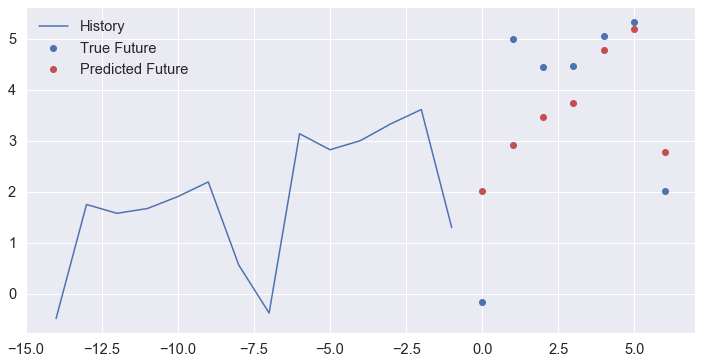

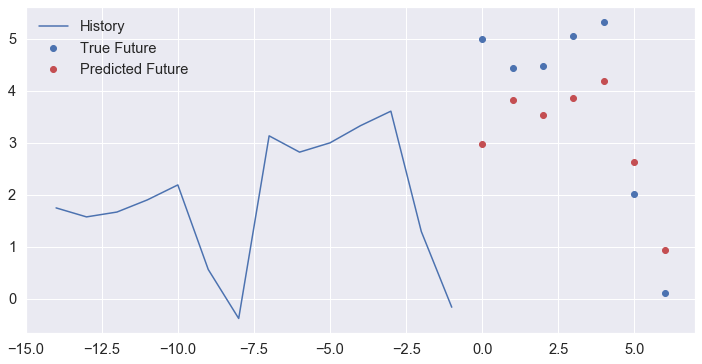

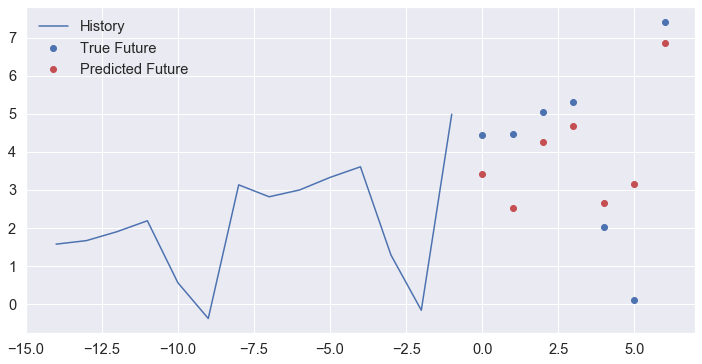

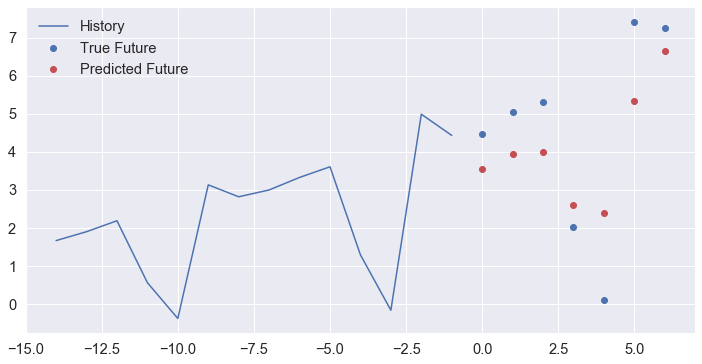

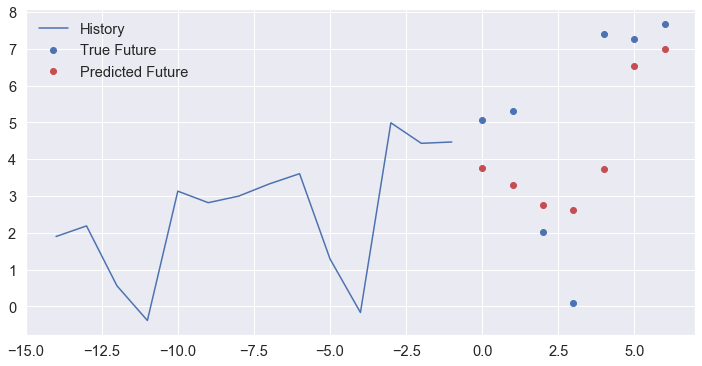

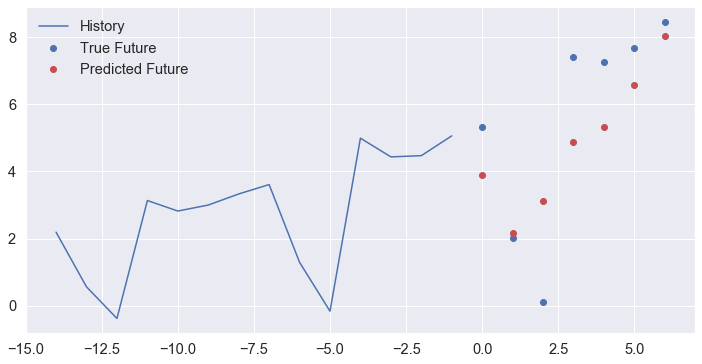

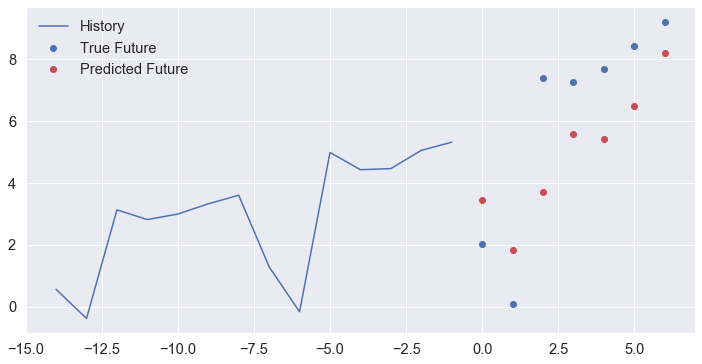

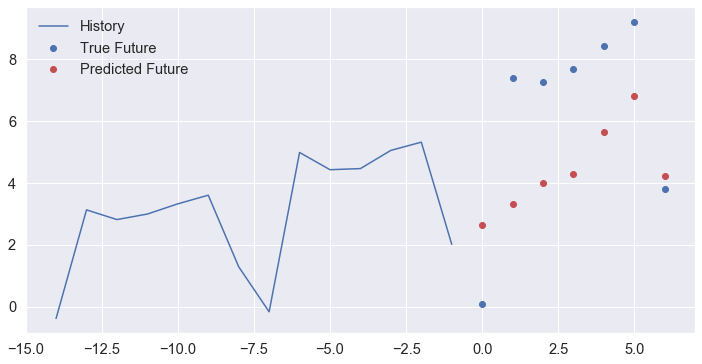

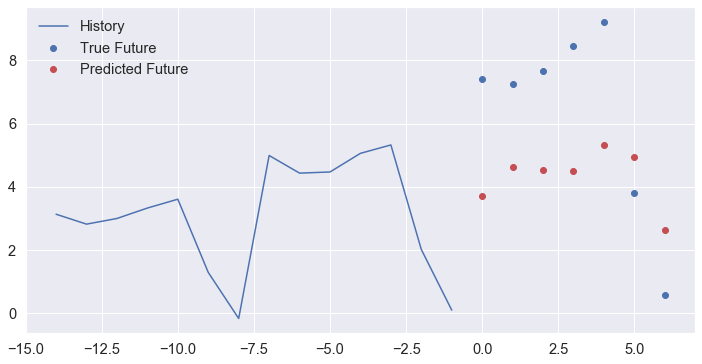

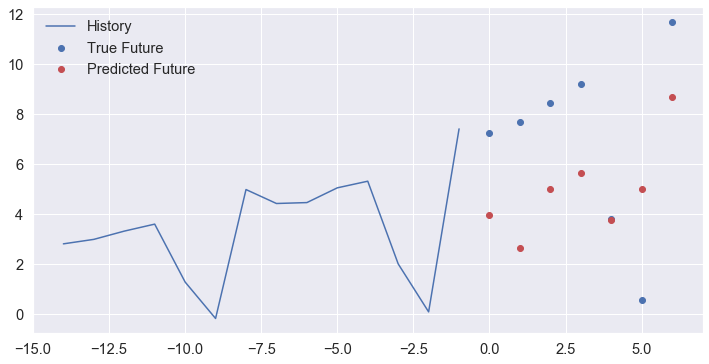

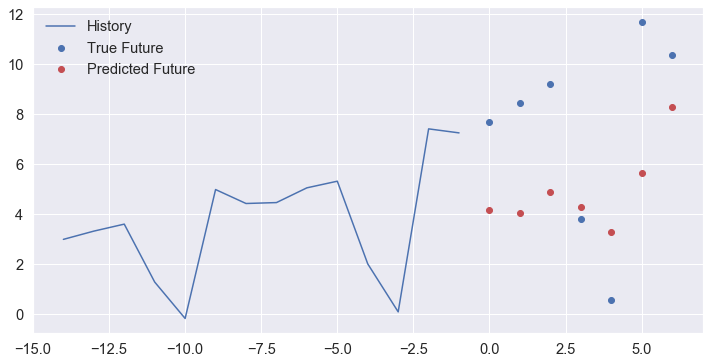

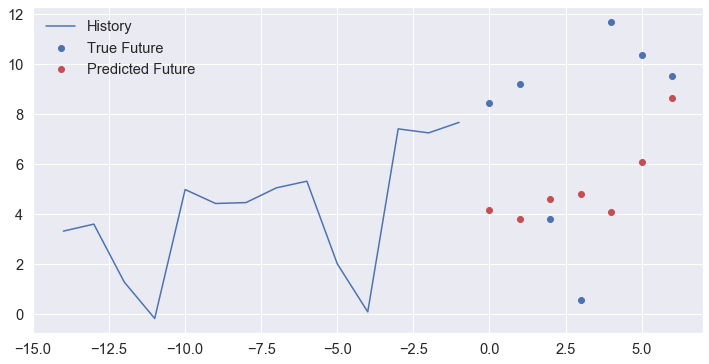

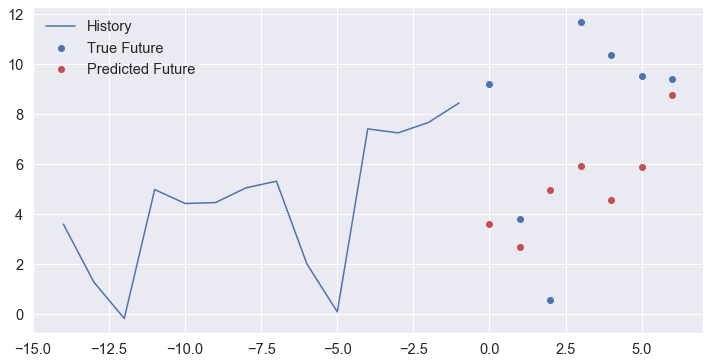

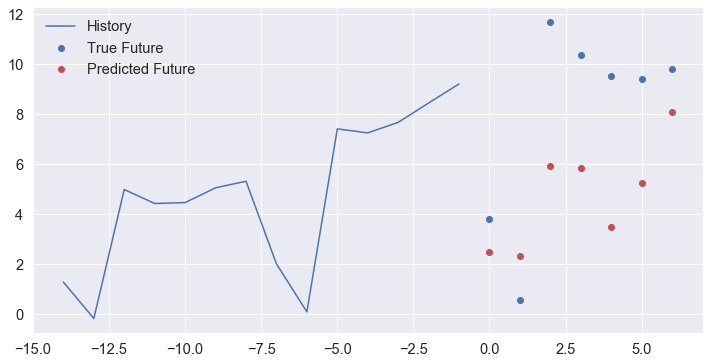

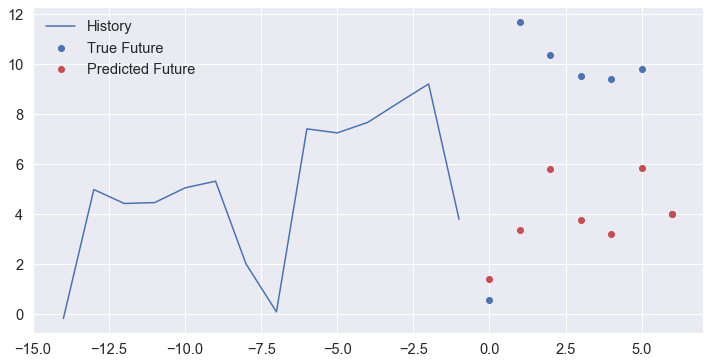

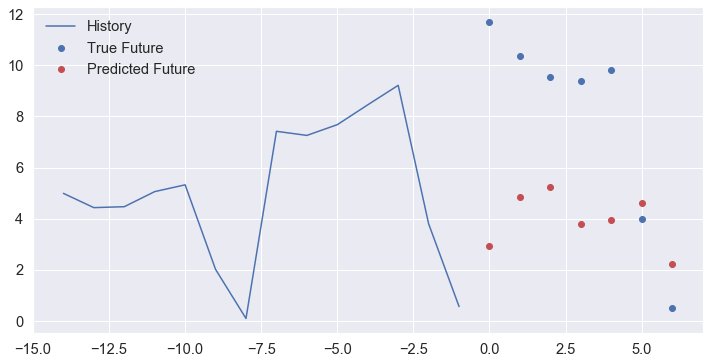

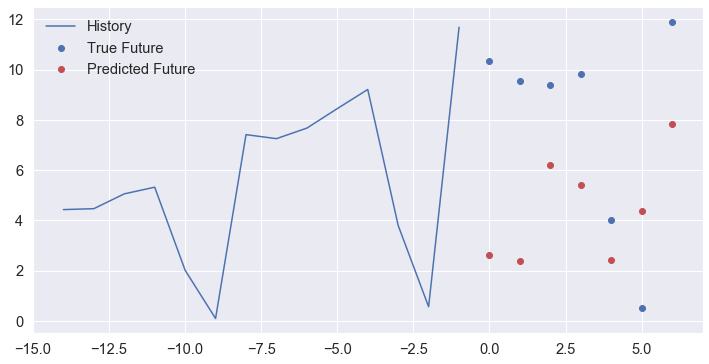

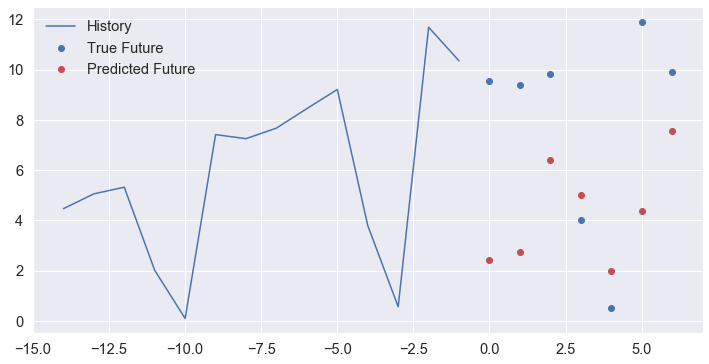

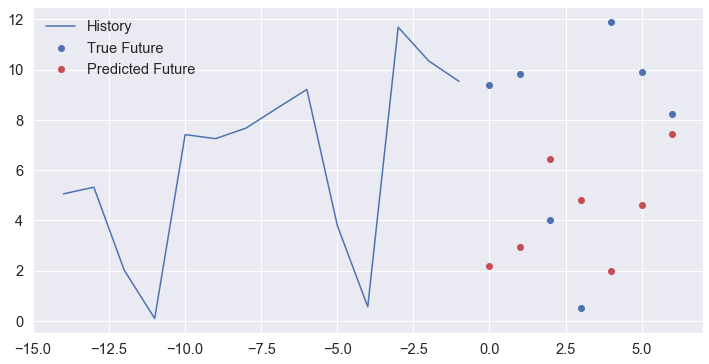

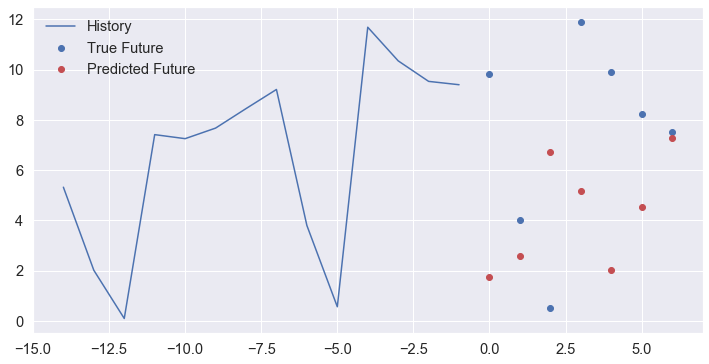

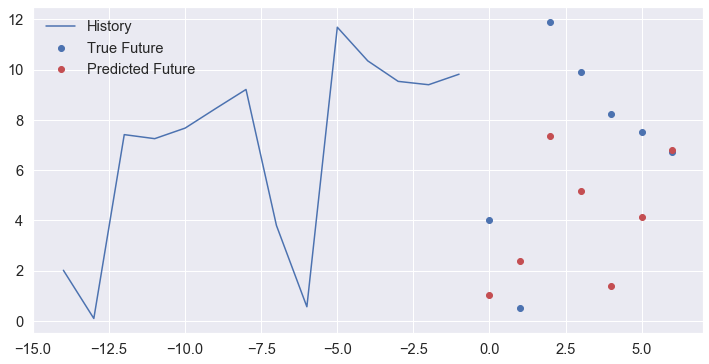

In [80]:
for x, y in val_data_multi.take(1):
    for I in range(y_val_multi_pred.shape[0]):
        multi_step_plot(x[I], y[I], multi_step_model.predict(x)[I])

### Final Future Prediction

In [209]:
nb_period_plot = 9 #23
NB_DAY_PLOT = FUTURE_TARGET*nb_period_plot

In [210]:
PATH_MDL_MULTI_STEP

'./mdl_multi_step_pos_fr'

In [211]:
# reload best model
multi_step_model = tf.keras.models.load_model(PATH_MDL_MULTI_STEP)


Two checkpoint references resolved to different objects (<tensorflow.python.keras.layers.recurrent_v2.LSTM object at 0x1a43380c50> and <tensorflow.python.keras.layers.core.Dropout object at 0x1a433cc2d0>).

Two checkpoint references resolved to different objects (<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x1a433ccb50> and <tensorflow.python.keras.layers.core.Dense object at 0x1a433d5110>).

Two checkpoint references resolved to different objects (<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x1a433ccb50> and <tensorflow.python.keras.layers.core.Dropout object at 0x1a433cc2d0>).


In [212]:
TRAIN_SPLIT

151

In [213]:
# reload data
df_feat_fr = pd.read_csv(PATH_DF_FEAT_FR)
df_feat_fr.index = df_feat_fr["date"]
# prepare features
features = df_feat_fr.copy().filter(items=['T_min', 'T_max', 'H_min',
                                           'H_max', 'pos', 'test', 'day_num',
                                          'age_pos', 'age_test'])
# calculate mean & std 
#TRAIN_SPLIT = 93
# prepare dataset
dataset = features.values
data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
data_std = dataset[:TRAIN_SPLIT].std(axis=0)

dataset = (dataset-data_mean)/data_std

In [214]:
df_feat_fr.shape

(179, 12)

In [215]:
%%time
# prepare data : very last days
x_multi = np.array([dataset[-PAST_HISTORY:,:]]) 
# predict next days
y_multi_pred = multi_step_model.predict(x_multi)
y_multi_pred

# convert in positive cases
y_pos_pred = y_multi_pred * data_std[4] + data_mean[4]


CPU times: user 490 ms, sys: 51.9 ms, total: 542 ms
Wall time: 677 ms


In [216]:
df_feat_fr.date.min()

'2020-05-13'

In [217]:
df_feat_fr.date.max()

'2020-11-07'

In [218]:
df_feat_fr.pos.std()

15318.932630059397

In [219]:
data_std[4]

5471.994767302769

In [220]:
str_date_0 = add_days(df_feat_fr.date.max(), -NB_DAY_PLOT)
str_date_0

'2020-09-05'

In [221]:
# last nth days
df_plot = df_feat_fr[df_feat_fr["date"] >= str_date_0].copy()

# add pos pred next days from last day : date, pos, total (sum)
str_date_pred_0 = df_feat_fr.date.max()
str_date_pred_1 = add_days(str_date_pred_0, FUTURE_TARGET)
list_dates_pred = generate_list_dates(str_date_pred_0, str_date_pred_1)
# figure 
df_plot_pred = pd.DataFrame(index=list_dates_pred, columns=["date"], 
                       data=list_dates_pred)

df_plot_pred["pos"] = y_pos_pred[0].astype(int)
arr_nb_pred = df_plot_pred["pos"].cumsum().values
df_plot_pred["nb_cases"] = df_plot["nb_cases"].max() + arr_nb_pred
    
df_plot_pred

date    pos  nb_cases
2020-11-08  2020-11-08  12145   1813375
2020-11-09  2020-11-09  22969   1836344
2020-11-10  2020-11-10  30835   1867179
2020-11-11  2020-11-11  21485   1888664
2020-11-12  2020-11-12  23049   1911713
2020-11-13  2020-11-13  35435   1947148
2020-11-14  2020-11-14  21400   1968548

In [222]:
df_feat_fr.iloc[TRAIN_SPLIT]["date"]

'2020-10-11'

In [223]:
df_plot

T_min        date       T_max      H_min      H_max  extrap  \
date                                                                           
2020-09-05  288.856667  2020-09-05  296.695000  51.465517  85.793103     0.0   
2020-09-06  287.591667  2020-09-06  295.071667  52.034483  86.913793     0.0   
2020-09-07  286.353333  2020-09-07  295.921667  48.576271  86.966102     0.0   
2020-09-08  287.520000  2020-09-08  297.913333  49.067797  83.932203     0.0   
2020-09-09  288.890000  2020-09-09  298.401667  52.542373  86.491525     0.0   
...                ...         ...         ...        ...        ...     ...   
2020-11-03  284.926667  2020-11-03  290.505000  64.661017  88.135593     1.0   
2020-11-04  284.926667  2020-11-04  290.505000  64.661017  88.135593     1.0   
2020-11-05  284.858475  2020-11-05  286.180508  74.310345  80.517241     0.0   
2020-11-06  284.926667  2020-11-06  290.505000  64.661017  88.135593     1.0   
2020-11-07  284.926667  2020-11-07  290.505000  64.661017  88.135593     1.0   

              pos    age_pos    test   age_test  day_num  nb_cases  
date                                                                
2020-09-05   3945  41.130545   77227  44.107385        6    337510  
2020-09-06   1395  42.594982   22324  44.431598        0    338905  
2020-09-07  12074  41.058970  198201  44.134570        1    350979  
2020-09-08  11497  40.209881  199000  41.771598        2    362476  
2020-09-09  11140  40.459425  194687  41.124610        3    373616  
...           ...        ...     ...        ...      ...       ...  
2020-11-03  58149  49.026105  272472  48.344410        2   1651321  
2020-11-04  49175  48.602806  247489  47.367398        3   1700496  
2020-11-05  45135  48.587859  248770  47.525723        4   1745631  
2020-11-06  40911  48.603456  243638  48.060647        5   1786542  
2020-11-07  14688  48.260825   90621  46.813520        6   1801230  

[64 rows x 12 columns]

### Figure

In [224]:
# Create figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Create and style traces
# total
fig.add_trace(go.Scatter(x=df_plot["date"].astype(np.datetime64), 
                         y=df_plot["nb_cases"],
                    mode='lines+markers',
                    line_shape='linear',
                    connectgaps=True, name="Total cases"),
             secondary_y=False)

fig.add_trace(go.Scatter(x=df_plot_pred["date"].astype(np.datetime64), 
                         y=df_plot_pred["nb_cases"],
                    mode='lines+markers',
                    line_shape='linear',
                    connectgaps=True, name="Total predicted"),
             secondary_y=False)
# new cases
fig.add_trace(go.Bar(x=df_plot["date"].astype(np.datetime64), 
                     y=df_plot["pos"], 
                     name="New cases"), 
             secondary_y=True)

fig.add_trace(go.Bar(x=df_plot_pred["date"].astype(np.datetime64), 
            y=df_plot_pred["pos"], 
            name="New predicted"), 
            secondary_y=True)
# Edit the layout
title_fig = '<b>COVID-19 Confirmed cases in France with prediction</b><br>' + \
    'LMST Deep Learning Model : ' + \
    'prediction of <b>{} days</b>'.format(FUTURE_TARGET) + \
    ' from <b>last {} days</b>'.format(PAST_HISTORY) + \
    '<br>Trained until ' + df_feat_fr.iloc[TRAIN_SPLIT]["date"]

fig.update_layout(title=title_fig,
                   yaxis_title='nb confirmed cases')
fig.update_layout(legend_orientation="h", legend=dict(x=0, y=1))

fig.update_yaxes(title_text="daily cases", secondary_y=True)

fig.show()


### Predict all past

In [225]:
nb_period_plot

9

In [226]:
19*7

133

In [227]:
179-4*7

151

In [228]:
dataset.shape

(179, 9)

In [229]:
%%time
# prepare list of past histories
list_x = create_list_past_hist(dataset, nb_period_plot=nb_period_plot)
# predict
y_multi_pred = predict_list(list_x, multi_step_model)
# convert in positive cases
y_pos_pred = (y_multi_pred * data_std[4]) + data_mean[4] 
y_pos_pred

[102 - 116]
[109 - 123]
[116 - 130]
[123 - 137]
[130 - 144]
[137 - 151]
[144 - 158]
[151 - 165]
[158 - 172]
9
CPU times: user 452 ms, sys: 30.1 ms, total: 482 ms
Wall time: 738 ms


array([[ 3939.3372,  8671.328 , 10681.807 ,  9850.738 , 10259.775 ,
         9968.207 ,  4615.0566,  5116.8994, 10764.777 , 12872.492 ,
        11859.648 , 12370.217 , 11443.701 ,  4779.753 ,  4340.3955,
        10365.508 , 12824.123 , 10863.404 , 10866.531 , 10637.943 ,
         4119.9316,  7119.7573, 11535.655 , 12965.891 , 13314.344 ,
        15730.871 , 16145.324 ,  8971.309 , 12271.264 , 17253.934 ,
        18624.254 , 19952.496 , 24584.664 , 24774.408 , 13455.133 ,
        14981.826 , 19966.354 , 22976.053 , 24463.148 , 30132.576 ,
        32451.93  , 19206.39  , 18516.473 , 22277.86  , 25954.486 ,
        27499.713 , 35031.68  , 41391.87  , 27221.21  , 11792.207 ,
        22521.59  , 35764.06  , 24582.168 , 21648.107 , 36056.44  ,
        26005.775 ,  6422.277 , 22021.662 , 39108.523 , 20120.156 ,
        12270.412 , 32202.367 , 23885.967 ]], dtype=float32)

In [230]:
y_pos_pred.shape

(1, 63)

In [231]:
# create df out prediction
K_days = y_pos_pred.shape[1]
str_date_pred_1 = df_feat_fr.date.max()
str_date_pred_0 = add_days(str_date_pred_1, -1*K_days)
list_dates_pred = generate_list_dates(str_date_pred_0, str_date_pred_1)
print(len(list_dates_pred))
print(str_date_pred_0)
print(str_date_pred_1)

df_plot_pred_all = pd.DataFrame(index=list_dates_pred, columns=["date"], 
                       data=list_dates_pred)

df_plot_pred_all["pos"] = y_pos_pred[0].astype(int)

list_nb_cases =[]
str_date_nb_0 = str_date_pred_0
for I in range(0, df_plot_pred_all["pos"].shape[0], FUTURE_TARGET):
    str_date_nb_0 = add_days(str_date_pred_0, I)
    nb_0 = df_feat_fr[df_feat_fr["date"] == str_date_nb_0]["nb_cases"][0]
    arr_nb = nb_0 + \
        df_plot_pred_all.iloc[I:I+FUTURE_TARGET]["pos"].cumsum().values
    list_nb_cases = list_nb_cases + arr_nb.tolist()
df_plot_pred_all["nb_cases"] = list_nb_cases


df_plot_pred_all

63
2020-09-05
2020-11-07


date    pos  nb_cases
2020-09-06  2020-09-06   3939    341449
2020-09-07  2020-09-07   8671    350120
2020-09-08  2020-09-08  10681    360801
2020-09-09  2020-09-09   9850    370651
2020-09-10  2020-09-10  10259    380910
...                ...    ...       ...
2020-11-03  2020-11-03  39108   1584839
2020-11-04  2020-11-04  20120   1604959
2020-11-05  2020-11-05  12270   1617229
2020-11-06  2020-11-06  32202   1649431
2020-11-07  2020-11-07  23885   1673316

[63 rows x 3 columns]

### Figure all past 

In [232]:
str_date_mdl =  df_feat_fr.iloc[TRAIN_SPLIT]["date"]

In [292]:
# Create figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])
# Create and style traces
# total
fig.add_trace(go.Scatter(x=df_plot["date"].astype(np.datetime64), 
                         y=df_plot["nb_cases"],
                    mode='lines+markers',
                    line_shape='linear',
                    line_color="blue",
                    connectgaps=True, name="Total"),
             secondary_y=False)
fig.add_trace(go.Scatter(x=df_plot_pred_all["date"].astype(np.datetime64), 
                         y=df_plot_pred_all["nb_cases"],
                    mode='lines+markers',
                    line_shape='hv',
                    line_color="red",
                    connectgaps=True, name="Total (estim.)"),
             secondary_y=False)
fig.add_trace(go.Scatter(x=df_plot_pred["date"].astype(np.datetime64), 
                         y=df_plot_pred["nb_cases"],
                    mode='lines+markers',
                    line_shape='hv',
                    line_color="orange",
                    connectgaps=True, name="Total (future estim.)"),
             secondary_y=False)
# new cases
fig.add_trace(go.Bar(x=df_plot["date"].astype(np.datetime64), 
                     y=df_plot["pos"], 
                     name="Daily", opacity=0.33, marker_color="blue"), 
             secondary_y=True)
fig.add_trace(go.Bar(x=df_plot_pred["date"].astype(np.datetime64), 
            y=df_plot_pred["pos"], 
            name="Daily (future estim.)", opacity=0.33, marker_color="orange"), 
            secondary_y=True)
fig.add_trace(go.Scatter(x=df_plot_pred_all["date"].astype(np.datetime64), 
                         y=df_plot_pred_all["pos"],
                    mode='lines+markers',
                    marker_symbol="cross",
                    line_color="red", opacity=0.33,    
                    connectgaps=True, name="Daily (estim.)"),
             secondary_y=True)
# Edit the layout
title_fig = '<b>COVID-19 Confirmed cases in France</b>' + \
    '<br>Model trained until <b>' + str_date_mdl + '</b>' + \
    '<br>predicts next {} days with last {} days until <b>' \
    .format(FUTURE_TARGET, PAST_HISTORY) + \
    df_plot_pred["date"].max() + '</b>'
fig.update_layout(title=title_fig, yaxis_title='nb <b>Total</b> cases')
fig.update_layout(legend_orientation="h", legend=dict(x=0, y=1))
fig.update_layout(height=600)

fig.update_yaxes(title_text="nb <b>Daily</b> cases", 
                secondary_y=True)
    
fig.show()


In [242]:
# Create figure with secondary y-axis
#fig = make_subplots()
fig = make_subplots(specs=[[{"secondary_y": True}]])

fig.add_trace(go.Bar(x=df_plot_pred["date"].astype(np.datetime64), 
            y=df_plot_pred["pos"], 
            name="Daily (future estim.)", opacity=0.5), 
            secondary_y=True)

fig.add_trace(go.Bar(x=df_plot["date"].astype(np.datetime64), 
                     y=df_plot["pos"], 
                     name="Daily", opacity=0.5), 
             secondary_y=True)



fig.add_trace(go.Bar(x=df_plot_pred_all["date"].astype(np.datetime64), 
            y=df_plot_pred_all["pos"], 
            name="Daily (estim.)", opacity=0.5), 
            secondary_y=True)



fig.update_layout(barmode='group')
# Edit the layout
title_fig = '<b>COVID-19 Confirmed cases in France</b>' + \
    '<br>Model trained until <b>' + str_date_mdl + '</b>' + \
    '<br>predicts next {} days with last {} days until <b>' \
    .format(FUTURE_TARGET, PAST_HISTORY) + \
    df_plot_pred["date"].max() + '</b>'
fig.update_layout(title=title_fig, yaxis_title='nb <b>Total</b> cases')
fig.update_layout(legend_orientation="h", legend=dict(x=0, y=1))
fig.update_layout(height=600)

fig.update_yaxes(title_text="nb <b>Daily</b> cases", 
                secondary_y=True)
    
fig.show()